In [1]:
import os
import logging
from typing import Tuple, List, Dict, Optional
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

2024-11-24 22:36:37.406805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 22:36:37.427900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732487797.461699   43388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732487797.472292   43388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:36:37.509362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
class Config:
    """Configuration class to store all hyperparameters and settings"""
    def __init__(self):
        # Data parameters
        self.IMAGE_SIZE = (224, 224)
        self.NUM_CHANNELS = 3
        self.NUM_CLASSES = 8
        self.INPUT_SHAPE = (*self.IMAGE_SIZE, self.NUM_CHANNELS)
        
        # Training parameters
        self.BATCH_SIZE = 2
        self.EPOCHS = 100
        self.INITIAL_LEARNING_RATE = 0.0001
        self.MIN_LEARNING_RATE = 0.00001
        self.VALIDATION_SPLIT = 0.2  
        
        # Data augmentation parameters
        self.ROTATION_RANGE = 20
        self.ZOOM_RANGE = 0.2
        self.HORIZONTAL_FLIP = True
        self.VERTICAL_FLIP = False
        self.FILL_MODE = 'nearest'
        
        # Paths
        self.DATA_PATH = 'dataset3'
        self.MODEL_SAVE_PATH = 'models'
        self.LOG_DIR = 'logs'
        
        # Class colors for visualization
        self.CLASS_COLORS = {
            "Bareland": (128, 0, 0), # Dark Red
            "Rangeland": (0, 255, 36), # Bright Green
            "Developed space": (148, 148, 148), # Grey
            "Road": (255, 255, 255), # White
            "Tree": (34, 97, 38), # Dark Green
            "Water": (0, 69, 255), # Blue
            "Agriculture land": (75, 181, 73), #  Light Green
            "Building": (222, 31, 7) # Red
}

In [3]:
class Metrics:
    """Custom metrics for semantic segmentation"""

    @staticmethod
    def dice_coefficient(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-6) -> tf.Tensor:
        y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return (2.0 * intersection + smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
        )

    @staticmethod
    def iou_coefficient(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-6) -> tf.Tensor:
        y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
        )
        return (intersection + smooth) / (union + smooth)

In [4]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('models/48.keras', custom_objects={
    'dice_coefficient': Metrics.dice_coefficient,
    'iou_coefficient': Metrics.iou_coefficient
})


I0000 00:00:1732487805.937390   43388 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:02:00.0, compute capability: 8.6
/home/rohiit/Public/SIH/deep-learning/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 166 variables whereas the saved optimizer has 170 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path: str, target_size: Tuple[int, int] = (224, 224)):
    # Load and resize the image
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Normalize the pixel values to [0, 1]
    img_array = img_array / 255.0
    
    # Expand dimensions to match the model's input shape (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array


def predict_image(image_path: str):
    # Preprocess the input image
    img_array = preprocess_image(image_path)
    
    # Make a prediction
    prediction = model.predict(img_array)
    
    return prediction


def process_prediction(prediction: np.ndarray):
    # Get the class with the highest probability for each pixel
    predicted_mask = np.argmax(prediction, axis=-1)
    
    # Remove the batch dimension (if present)
    predicted_mask = predicted_mask.squeeze()
    
    return predicted_mask


In [6]:
import cv2
import matplotlib.pyplot as plt

def visualize_segmentation(image_path: str, predicted_mask: np.ndarray, config: Config):
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (config.IMAGE_SIZE[0], config.IMAGE_SIZE[1]))

    # Prepare a color map based on the predicted mask
    color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_idx in range(config.NUM_CLASSES):
        color_mask[predicted_mask == class_idx] = config.CLASS_COLORS[list(config.CLASS_COLORS.keys())[class_idx]]

    # Overlay the mask on the original image
    overlay = cv2.addWeighted(original_image, 0.7, color_mask, 0.3, 0)
    
    print('Original Image',original_image.shape)
    print('Predicted Mask',predicted_mask.shape)
    # Display the result
    plt.imshow(overlay)
    plt.axis('off')  # Hide axes
    plt.show()

    # Optionally, save the result to a file
    cv2.imwrite('segmentation_result.jpg', overlay)


In [7]:
# Example usage
image_path = 'image_1.png'
prediction = predict_image(image_path)

# Process the prediction to get the class labels
predicted_mask = process_prediction(prediction)

cv2.imwrite('mask.png', predicted_mask)
# Visualize the segmentation result


2024-11-24 22:36:50.109421: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1732487810.123071   43524 service.cc:148] XLA service 0x7f3bd801c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732487810.123272   43524 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-11-24 22:36:50.151846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732487810.389866   43524 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1732487814.892152   43524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


True

Original Image (224, 224, 3)
Predicted Mask (224, 224)


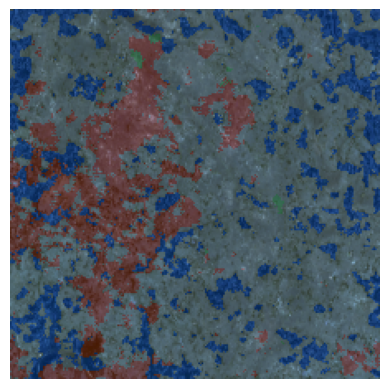

In [8]:
visualize_segmentation(image_path, predicted_mask, Config())
